## Figure 2

In [110]:
# imports
import eelbrain as eb
import matplotlib
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

# define colors
color_clear = matplotlib.colors.to_rgb('#40498eff')
color_dist = matplotlib.colors.to_rgb('#38aaacff')

Permutation test: 100%|██████████| 10000/10000 [00:09<00:00, 1039.52 permutations/s]


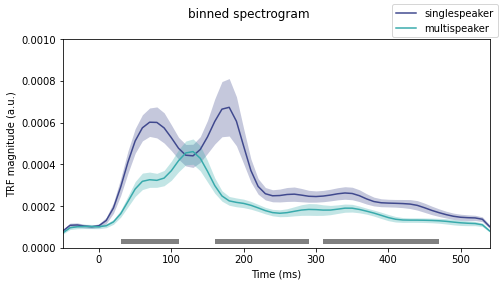

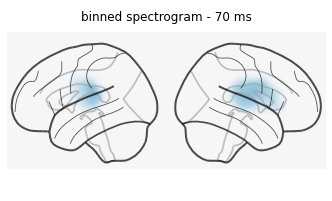

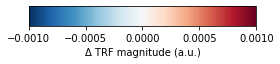

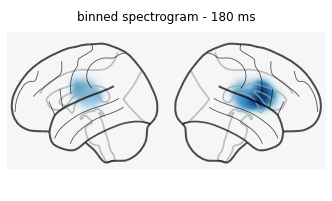

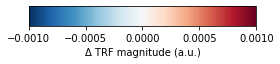

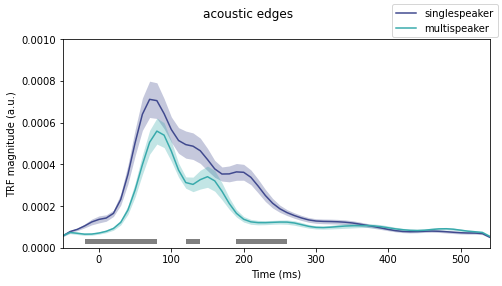

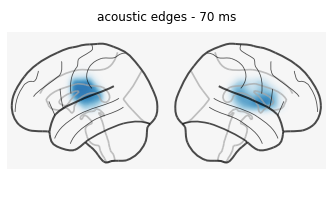

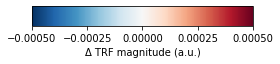

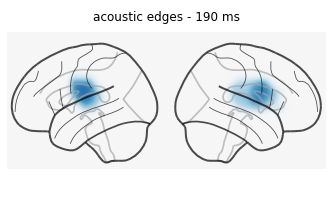

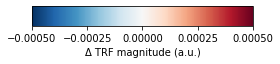

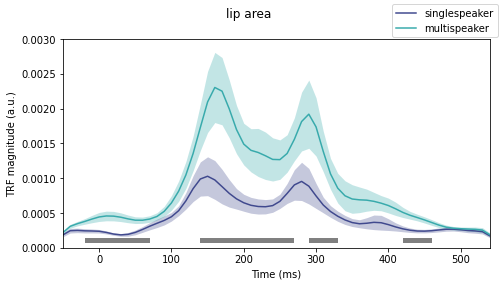

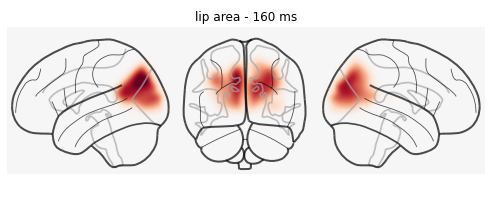

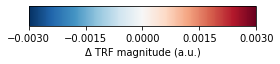

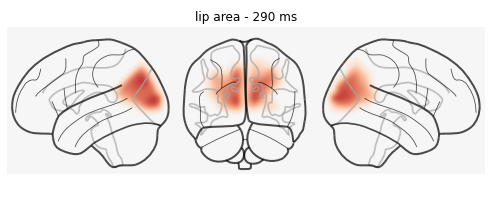

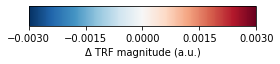

In [9]:
# plot figure 2A

# settings
features = ["binned spectrogram", "acoustic edges", "lip area"]

for idx_feat in features:
    # load data
    if idx_feat == "lip area":
        ds = eb.load.unpickle("./data/trfs/trfs_lip.pickle")
    else:
        ds = eb.load.unpickle("./data/trfs/trfs_acoustic.pickle")

    # t-test
    ds_sub = ds.sub((ds['feature'] == idx_feat))
    ds_sub["trf"] = ds_sub["trf"].sub(time=(-0.05, 0.55)).norm("space").mean("source")
    ttest_trfs = eb.testnd.TTestRelated('trf', 'cond', match='subject_id', 
                                        ds=ds_sub, tfce=True, c0="no_mask_clear", c1="no_mask_dist")
    clusters = ttest_trfs.find_clusters(maps=True)

    # plot TRFs
    ds_sub_plot = ds.sub(ds['feature'] == idx_feat)
    ds_sub_plot["trf"] = ds_sub_plot["trf"].sub(time=(-0.05, 0.55)).norm("space").mean("source")

    ds_sub_plot_smooth = ds_sub_plot
    ds_sub_plot_smooth["trf"] = ds_sub_plot["trf"].smooth("time", window_size=0.05)

    fig = eb.plot.UTSStat(y="trf", x="cond", ds=ds_sub_plot_smooth, title=idx_feat, 
                        labels={"no_mask_clear": "singlespeaker", "no_mask_dist": "multispeaker"}, 
                        colors=[color_clear, color_dist], h=4, w=7)

    fig.set_xlabel("Time (ms)")
    fig.set_ylabel("TRF magnitude (a.u.)")
    
    # set ylims & condition for peak detection
    if idx_feat == "lip area":
        fig.set_ylim((0, 0.003))
        clusterlim = 0.0001
        peak_cond = 'no_mask_dist'
    else:
        fig.set_ylim((0, 0.001))
        clusterlim = 0.00003
        peak_cond = 'no_mask_clear'

    fig.set_clusters(clusters, y=clusterlim, color='0.5')

    # get TRF peaks
    ds_sub_peaks = ds_sub_plot.sub(ds_sub_plot['cond'] == peak_cond)
    ds_sub_peaks["trf"] = ds_sub_peaks["trf"].sub(time=(-0.05, 0.55))
    peaks = scipy.signal.find_peaks(ds_sub_peaks["trf"].mean("case").x, 
                                    height=ds_sub_peaks["trf"].mean("case").x.max()/2)[0]

    peaks_time = []
    for idx_peaks in range(len(peaks)):
        peaks_time.append(ds_sub_peaks["trf"].mean("case").time.times[peaks[idx_peaks]])

    #  get contrast
    ds_sub_clear = ds.sub((ds['cond'] == 'no_mask_clear') & (ds['feature'] == idx_feat))
    ds_sub_clear["trf"] = ds_sub_clear["trf"].sub(time=(-0.05, 0.55)).norm("space")

    ds_sub_dist = ds.sub((ds['cond'] == 'no_mask_dist') & (ds['feature'] == idx_feat))
    ds_sub_dist["trf"] = ds_sub_dist["trf"].sub(time=(-0.05, 0.55)).norm("space")

    ds_sub_diff = ds_sub_clear
    ds_sub_diff["trf"] = ds_sub_dist["trf"] - ds_sub_clear["trf"]
    
    # define limit of colorbar & views
    views = "lr"
    if idx_feat == "binned spectrogram":
        limit = 0.001
    elif idx_feat == "acoustic edges":
        limit = 0.0005
    else:
        limit = 0.003
        views = "lyr"
                
    # plot contrast of peaks
    for idx_pks in range(len(peaks_time)):
        fig = eb.plot.GlassBrain(ds_sub_diff["trf"].sub(time=peaks_time[idx_pks]), 
                                display_mode=views, interpolation="bicubic", annotate=False,
                                vmax=limit, cmap="RdBu_r", title=idx_feat + " - " + str(round(peaks_time[idx_pks]*1000)) + ' ms')
        fig.plot_colorbar(label = "Δ TRF magnitude (a.u.)")


Permutation test: 100%|██████████| 10000/10000 [00:12<00:00, 827.94 permutations/s]


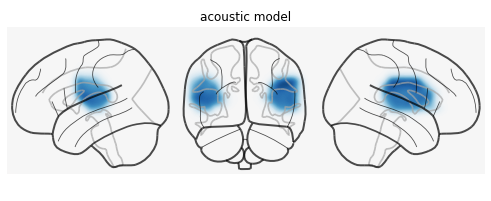

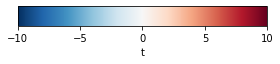

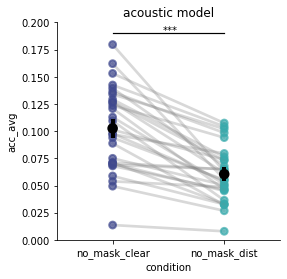

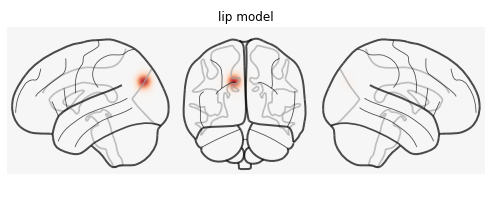

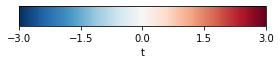

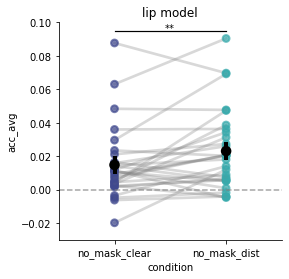

In [53]:
# plot figure 2B

# settings
models = ["acoustic", "lip"]

for idx_model in models:
    # load data
    if idx_model == "lip":
        ds_accs = eb.load.unpickle("./data/prediction_accuracies/accs_lip.pickle")
    else:
        ds_accs = eb.load.unpickle("./data/prediction_accuracies/accs_acoustic.pickle")

    ds_accs_df = ds_accs.as_dataframe()

    # define settings
    if idx_model == "lip":
        ylim_min = -0.03
        ylim_max = 0.1
        t_max = 3
    else:
        ylim_min = 0
        ylim_max = 0.2
        t_max = 10

    # t-test
    ttest_accs = eb.testnd.TTestRelated('acc', 'condition', match='subject_id', 
                                        ds=ds_accs, tfce=True, c0="no_mask_clear", c1="no_mask_dist")
    clusters_accs = ttest_accs.find_clusters(maps=True)
    
    # plot non-averaged prediction accuracies
    fig = eb.plot.GlassBrain(ttest_accs.masked_parameter_map(), display_mode="lyr", 
                   title=idx_model + " model", interpolation="bicubic", 
                   cmap="RdBu_r", vmax=t_max, annotate=False)
    fig.plot_colorbar(label="t")
    
    # plot averaged prediction accuracies
    fig1 = plt.figure(figsize=(4, 4))
    fig1 = sns.pointplot(x='condition', y='acc_avg', hue="subject_id", data=ds_accs_df, palette="mako")
    
    fig1.set_title(idx_model + " model")
    fig1.set_ylim(ylim_min, ylim_max)
    fig1.set_xlabel("condition")
    fig1.set_ylabel("prediction accuracy (r)")
    fig1.set_xticklabels(["singlespeaker", "multispeaker"])
    fig1.get_legend().remove()
    sns.despine()
    plt.setp(fig1.lines, alpha=.3, color="grey")
    plt.setp(fig1.collections, color=[color_clear, color_dist], alpha=0.7)
       
    if idx_model == "acoustic":
        fig1.text(x=0.45, y=ylim_max-0.01, s="***")
        fig1.axhline(y=ylim_max-0.01, xmin=0.25, xmax=0.75, color='black', linestyle="solid", linewidth=1.2)
    else:
        fig1.text(x=0.45, y=ylim_max-0.005, s="**")
        fig1.axhline(0, color='grey', linestyle="dashed", alpha=0.7, zorder=0)
        fig1.axhline(y=ylim_max-0.005, xmin=0.25, xmax=0.75, color='black', linestyle="solid", linewidth=1.2)
    
    fig2 = sns.pointplot(x="condition", y='acc_avg', data=ds_accs_df, dodge=False,
        join=False, scale=1.2, errwidth=4, color="black", errorbar="se")
    plt.setp(fig2.lines, zorder=1)
    plt.setp(fig2.collections, zorder=1)
    
    # plot 

/tmp/ipykernel_27416/2606000432.py:9: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_bsl["model"].cat.remove_unused_categories(inplace=True)
/tmp/ipykernel_27416/2606000432.py:10: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df_bsl["model"].cat.rename_categories(["acoustic"], inplace=True)
/tmp/ipykernel_27416/2606000432.py:14: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_accs_add_val_long = ds_accs_add_val_df.melt(id_vars=["subject_id", "condition", "model"],


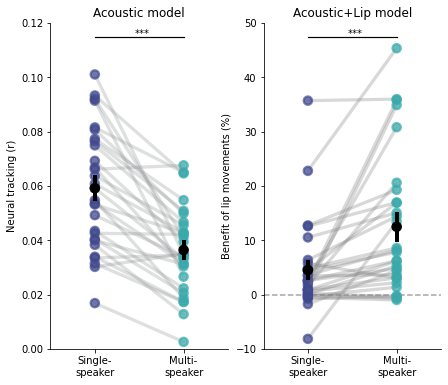

In [109]:
# plot figure 2C

# load data
ds_accs_add_val = eb.load.unpickle("./data/prediction_accuracies/accs_add_val.pickle")
ds_accs_add_val_df = ds_accs_add_val.as_dataframe()

# get acoustic model (baseline)
df_bsl = ds_accs_add_val_df.query("model == 'lip+acoustic'")
df_bsl["model"].cat.remove_unused_categories(inplace=True)
df_bsl["model"].cat.rename_categories(["acoustic"], inplace=True)

# bring dataframes in long format
df_bsl_long = df_bsl.melt(id_vars=["subject_id", "condition", "model"], value_vars="bsl_avg", value_name="acc")
df_accs_add_val_long = ds_accs_add_val_df.melt(id_vars=["subject_id", "condition", "model"],
                                               value_vars="add_val_avg_perc", value_name="add_val_avg_perc")

# plot
palette = "mako"
fig, axes = plt.subplots(1, 2, figsize=(7, 6))

fig1 = sns.pointplot(x='condition', y='acc', hue="subject_id", data=df_bsl_long, palette=palette, ax=axes[0], scale=1.2)
fig1.legend_.remove()
fig1.set_xlabel("condition")

plt.setp(fig1.collections, color=[color_clear, color_dist], alpha=0.7)
plt.setp(fig1.lines, alpha=.3, color=matplotlib.colors.to_rgb('#939597'))
plt.xlabel("acoustic+lip")

plt.setp(fig1, ylim=(0, 0.12), ylabel="prediction accuracy (r)", xlabel="condition", title="Acoustic model", xticklabels=["singlespeaker", "multispeaker"])

fig2 = sns.pointplot(x="condition", y='acc', data=df_bsl_long, color="black",
              join=False, scale=1.2, errwidth=4, ax=axes[0], errorbar="se")
plt.setp(fig2.lines, zorder=1)
plt.setp(fig2.collections, zorder=1)

fig3 = sns.pointplot(x='condition', y='add_val_avg_perc', hue="subject_id", data=df_accs_add_val_long, palette=palette,
                     scale=1.2)
plt.setp(fig3.collections, color=[color_clear, color_dist], alpha=0.7)
plt.setp(fig3.lines, alpha=.3, color="grey")

sns.despine()

plt.setp(fig3, ylim=(-10, 50), title="Acoustic+Lip model")

fig4 = sns.pointplot(x="condition", y='add_val_avg_perc', data=df_accs_add_val_long, color="black",
              join=False, scale=1.2, errwidth=4, ax=axes[1], errorbar="se")
plt.setp(fig4.lines, zorder=1)
plt.setp(fig4.collections, zorder=1)

fig3.legend_.remove()
fig3.axhline(0, color='grey', linestyle="dashed", alpha=0.7, zorder=0)

fig1.axhline(y=0.115, xmin=0.25, xmax=0.75, color='black', linestyle="solid", linewidth=1.2)
fig1.text(x=0.45, y=0.115, s="***")

fig3.axhline(y=47.5, xmin=0.25, xmax=0.75, color='black', linestyle="solid", linewidth=1.2)
fig3.text(x=0.45, y=47.5, s="***")

plt.setp([fig1, fig3], xticklabels=["Single-\nspeaker", "Multi-\nspeaker"], xlabel="")
plt.setp(fig1, ylabel="Neural tracking (r)")
plt.setp(fig3, ylabel="Benefit of lip movements (%)")
plt.show()